In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("/Users/edwardamoah/Documents/GitHub/osmiaBeePop/research/data/Centrella_et_al_Data.csv")
forage = pd.read_csv("/Users/edwardamoah/Documents/GitHub/osmiaBeePop/research/data/Centrella_Spring_Forage_2015.csv")
tmean = pd.read_csv("/Users/edwardamoah/Documents/GitHub/osmiaBeePop/research/data/tmean_data.csv")
ppt = pd.read_csv("/Users/edwardamoah/Documents/GitHub/osmiaBeePop/research/data/ppt_data.csv")

In [3]:
data['Total_Emerged_Adults'] = data['Total_Emerged_Females'] + data['Total_Emerged_Males']

In [4]:
# loading forage quality data
################# tmean data #################

cols = tmean.columns.tolist()

new_cols = []
for col in cols:
    if "PRISM_tmean" in col:
        new_cols.append(col.split("_")[-2])
    else:
        new_cols.append(col)
new_cols

tmean = tmean.rename(columns=dict(zip(tmean.columns, new_cols)))


tmean["grid_id"] = tmean['Site'] #tmean["col"].astype(str) + "_" + tmean["row"].astype(str)

def getTmean(site, day, month, year, tmean=tmean):
    '''
    Get temperature data for a given grid cell
    col: int, column number
    row: int, row number
    day: int, day of the month
    month: int, month of the year
    year: int, year
    tmean: pd.DataFrame, temperature data

    output:
    float, temperature in degrees celcius
    '''
    if month < 10:
        month = "0" + str(month)
    if day < 10:
        day = "0" + str(day)
    date = str(year) + "" + str(month) + "" + str(day)
    grid_id = site #str(col) + "_" + str(row)
    tmean = tmean[tmean["grid_id"] == grid_id][date].values[0]
    return tmean

############### ppt data #################

cols = ppt.columns.tolist()

new_cols = []
for col in cols:
    if "PRISM_ppt" in col:
        new_cols.append(col.split("_")[-2])
    else:
        new_cols.append(col)

ppt = ppt.rename(columns=dict(zip(ppt.columns, new_cols)))

ppt["grid_id"] = ppt['Site'] #ppt["col"].astype(str) + "_" + ppt["row"].astype(str)

def getPpt(site, day, month, year, ppt=ppt):
    '''
    Get precipitation data for a given grid cell
    col: int, column number
    row: int, row number
    day: int, day of the month
    month: int, month of the year
    year: int, year
    ppt: pd.DataFrame, precipitation data

    output:
    float, precipitation in mm
    '''
    if month < 10:
        month = "0" + str(month)
    if day < 10:
        day = "0" + str(day)
    date = str(year) + "" + str(month) + "" + str(day)
    grid_id = site #str(col) + "_" + str(row)
    ppt = ppt[ppt["grid_id"] == grid_id][date].values[0]
    return ppt

In [5]:
from datetime import datetime

def getReproduction(site, day, month, year, tmean=tmean, ppt=ppt, pt_h=5, td_h=13.9):
    '''
    Get reproduction data for a given site
    site: str, site code
    day: int, day of the month
    month: int, month of the year
    year: int, year
    tmean: pd.DataFrame, temperature data
    ppt: pd.DataFrame, precipitation data

    output:
    float, egg per day
    '''


    #day = 20
    #month = 5
    #year = 2015
    date = datetime(year, month, day)
    #site = 'AB'


    # get temperate for 6 days prior to the date
    date_new = date - pd.DateOffset(days=6)
    tmean = []
    ppt = []
    for i in range(6):
        temp_date = date_new + pd.DateOffset(days=i)
        day = temp_date.day
        month = temp_date.month
        year = temp_date.year
        tmean.append(getTmean(site, day, month, year))
        ppt.append(getPpt(site, day, month, year))


    tmean_avg = np.mean(tmean)
    ppt_avg = np.mean(ppt)

    forage_days = 0
    for i in range(6):
        td = tmean[i]
        pt = ppt[i]

        if td >= td_h and pt < pt_h:
            forage_days += 1

    return {
        "tmean": tmean,
        "ppt": ppt,
        "tmean_avg": tmean_avg,
        "ppt_avg": ppt_avg,
        "forage_days": forage_days
    }

In [6]:
data['Date'] = pd.to_datetime(data['Calendar_Date'])

data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_18288/3598007551.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Calendar_Date'])


In [7]:
data['reproduction'] = data.apply(lambda x: getReproduction(x['Site_Code'], x['day'], x['month'], x['year']), axis=1)

In [8]:
data["forage_days"] = [dt["forage_days"] for dt in data['reproduction'].tolist()]
data["tmean_avg"] = [dt["tmean_avg"] for dt in data['reproduction'].tolist()]
data["ppt_avg"] = [dt["ppt_avg"] for dt in data['reproduction'].tolist()]


In [9]:
forage = forage.query(' radius == "1km" ')
forage['Site_Code'] = forage['Site']
data = data.merge(forage[['Site_Code','value']], on="Site_Code")

In [10]:
data.head()

,Site_Code,Orchard_Area_m2,Time_Point,Calendar_Date,Site_Letters_in_Supplement,Ag_250m,Forest_250m,Open_250m,Other_250m,WetShrub_250m,...,Total_Emerged_Adults,Date,day,month,year,reproduction,forage_days,tmean_avg,ppt_avg,value
0,AB,8108.310,1,5/20/15,a,0.063348,0.135747,0.411765,0.004525,0.027149,...,15,2015-05-20,20,5,2015,"{'tmean': [9.19300079345703, 12.068000793457, ...",3,16.443667,3.468500,0.465625
1,AB,8108.310,2,5/28/15,a,0.063348,0.135747,0.411765,0.004525,0.027149,...,103,2015-05-28,28,5,2015,"{'tmean': [13.2430009841919, 7.86700057983398,...",3,16.853334,0.000000,0.465625
2,AB,8108.310,3,6/3/15,a,0.063348,0.135747,0.411765,0.004525,0.027149,...,26,2015-06-03,3,6,2015,"{'tmean': [23.052001953125, 17.2150001525879, ...",3,16.567168,9.503333,0.465625
3,BA,14269.631,1,5/25/15,b,0.598174,0.050228,0.118721,0.041096,0.054795,...,45,2015-05-25,25,5,2015,"{'tmean': [22.4860019683838, 14.9300003051758,...",1,12.163001,1.339833,0.343750
4,BA,14269.631,2,5/29/15,b,0.598174,0.050228,0.118721,0.041096,0.054795,...,106,2015-05-29,29,5,2015,"{'tmean': [7.03200054168701, 10.2450008392334,...",4,17.060501,0.019500,0.343750


In [11]:
predictors_general = [
    'Site_Code'
]

predictors_landscape = [  
    'value',  
    'Ag_1000m',
    'Forest_1000m',
    'Open_1000m',
    'Other_1000m',
    'ShrubWet_1000m',
    'Urban_1000m',
    'Apples_1000m',
    'Orchard_Area_m2',
    ]

predictors_weather = [
    'ppt_avg',
    'tmean_avg',
    'forage_days',
    'Temp_C',
]

#predictors = predictors_general + predictors_landscape + predictors_weather
predictors = predictors_landscape + predictors_weather

In [12]:
data['egg_per_day'] = data['Total_Emerged_Adults'] / data['Nest_Tubes for_Offspring_Analysis'] / 6

In [13]:
################### check normality assumption for all variables ####################

In [14]:
from scipy.stats import shapiro
# Perform Shapiro-Wilk test

stat, p = shapiro(data['egg_per_day'])

# Check if the data is normally distributed
if p > 0.05:
    print("The data is normally distributed.")
else:
    print("The data is not normally distributed.")


The data is normally distributed.


2.0751427044230372e-08
The data is not normally distributed.


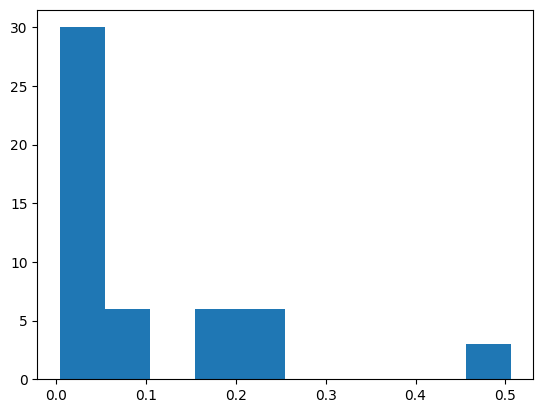

In [15]:
i = 1
data_temp = np.square(data[predictors[i]])
plt.hist(data_temp)

stat, p = shapiro(data_temp)

print(p)

# Check if the data is normally distributed
if p > 0.05:
    print("The data is normally distributed.")
else:
    print("The data is not normally distributed.")


Original Data:


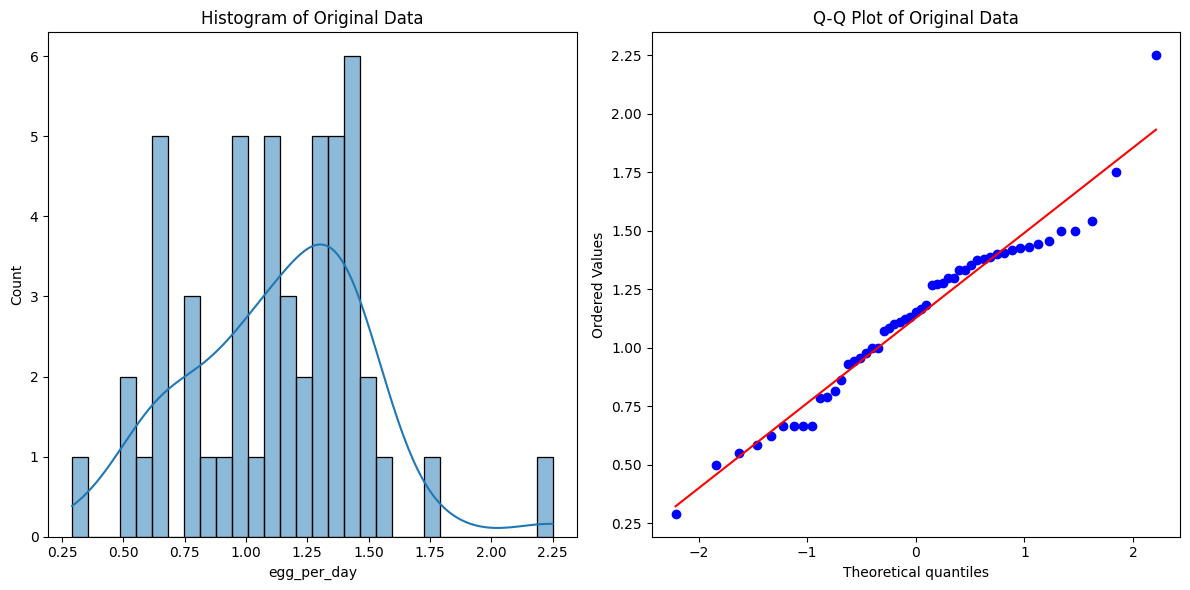

Original Data Transformation - Shapiro-Wilk Test p-value: 0.1322

Log Transformation:


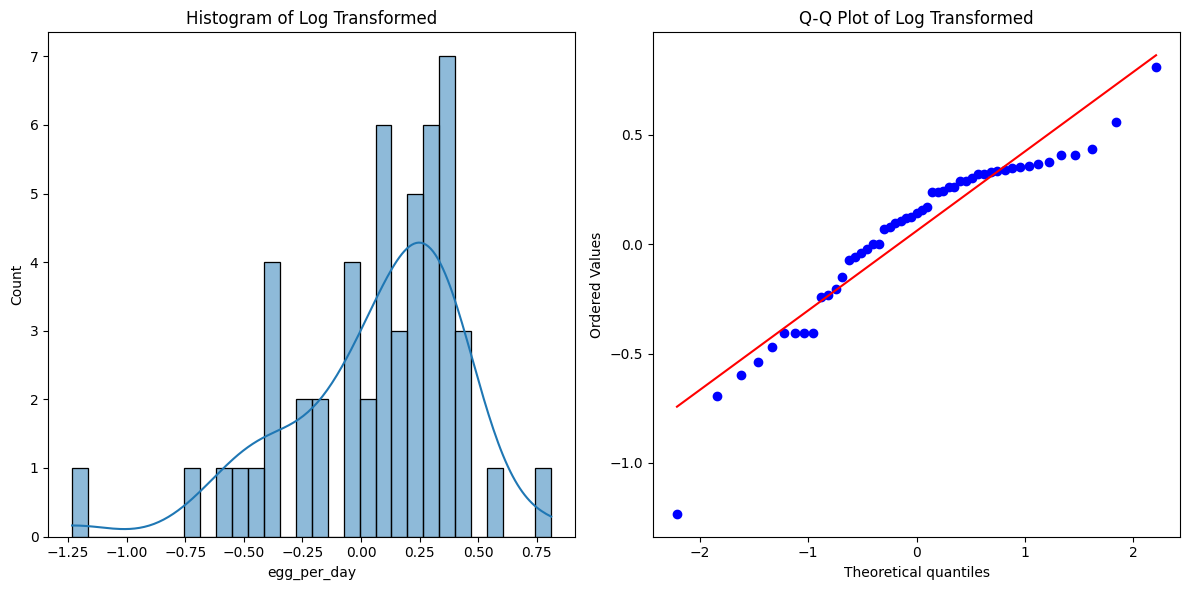

Log Transformed Transformation - Shapiro-Wilk Test p-value: 0.0015

Square Root Transformation:


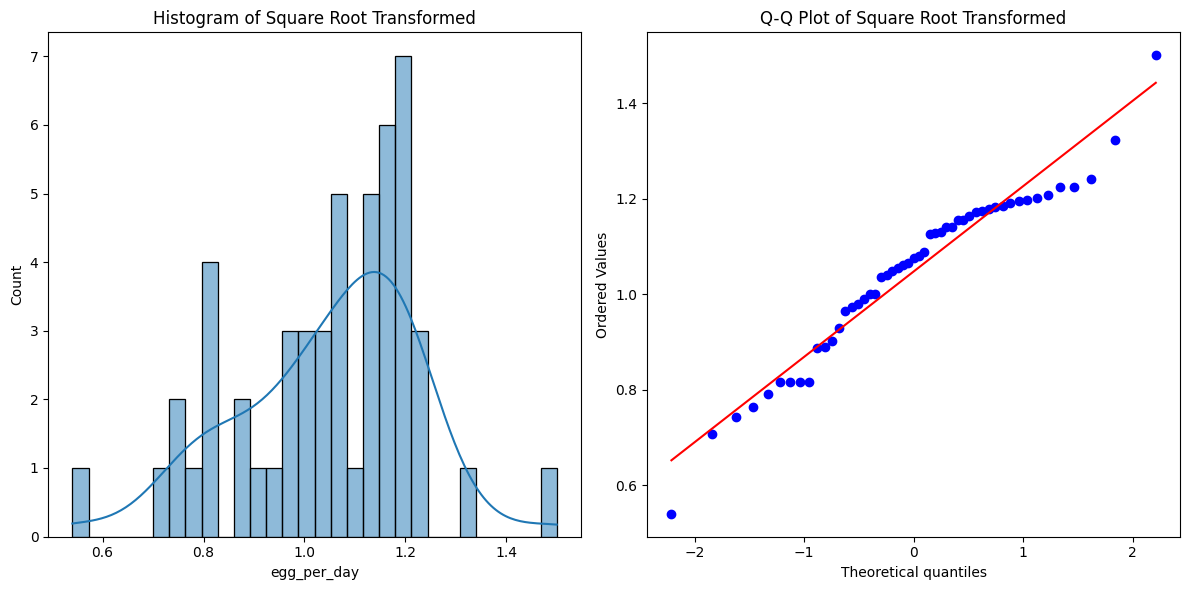

Square Root Transformed Transformation - Shapiro-Wilk Test p-value: 0.0650

Reciprocal Transformation:


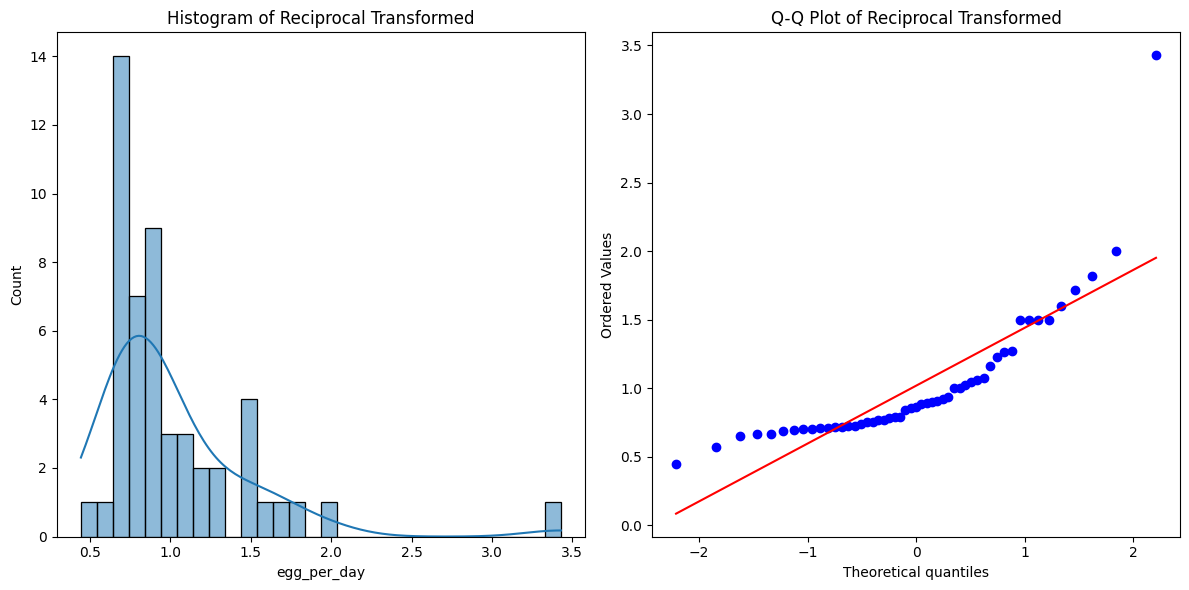

Reciprocal Transformed Transformation - Shapiro-Wilk Test p-value: 0.0000

Box-Cox Transformation:


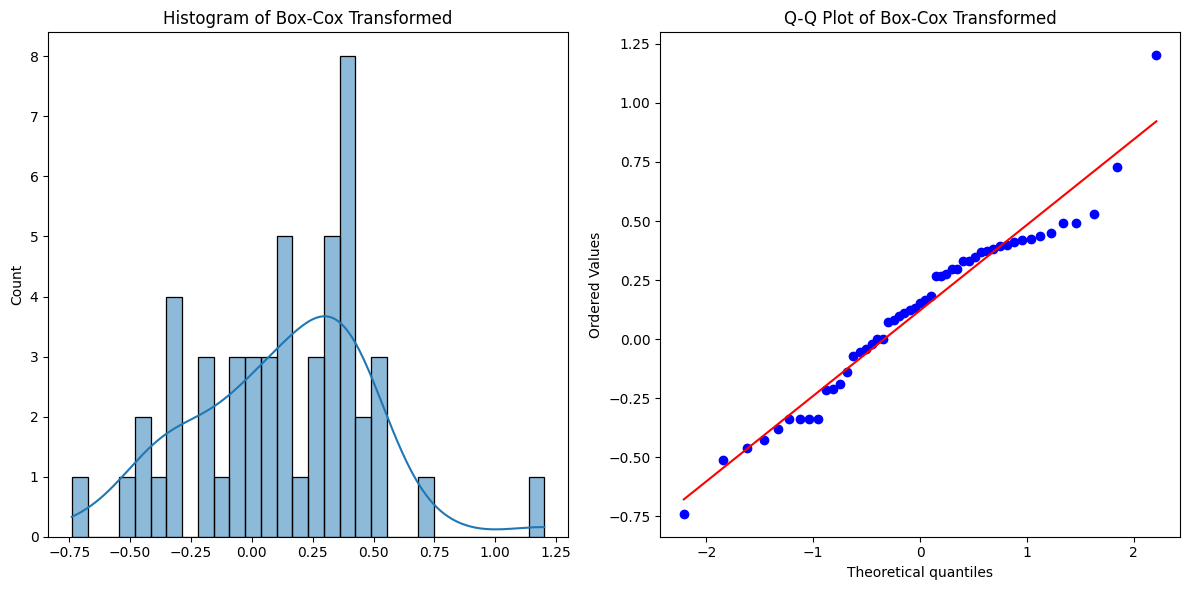

Box-Cox Transformed Transformation - Shapiro-Wilk Test p-value: 0.1472

Yeo-Johnson Transformation:


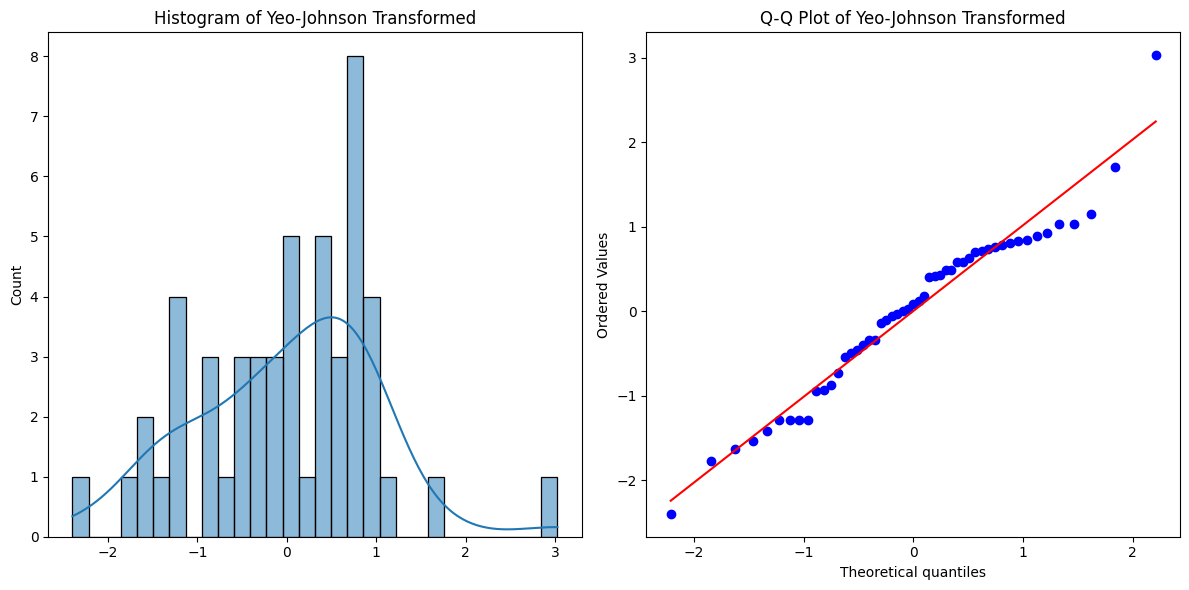

Yeo-Johnson Transformed Transformation - Shapiro-Wilk Test p-value: 0.1479


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer

# Function to plot the histogram and Q-Q plot
def plot_distribution(data, title):
    plt.figure(figsize=(12, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, bins=30)
    plt.title(f'Histogram of {title}')
    
    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {title}')
    
    plt.tight_layout()
    plt.show()

# Function to evaluate normality using Shapiro-Wilk test
def evaluate_normality(data, transformation_name):
    stat, p_value = stats.shapiro(data)
    print(f'{transformation_name} Transformation - Shapiro-Wilk Test p-value: {p_value:.4f}')
    return p_value

# Apply different transformations and evaluate
def try_transformations(data):
    # Drop NaN values for the transformations
    data_clean = data.dropna()

    # Original data
    print("\nOriginal Data:")
    plot_distribution(data_clean, "Original Data")
    evaluate_normality(data_clean, "Original Data")
    
    # Log Transformation (only for positive data)
    if (data_clean > 0).all():
        log_transformed = np.log(data_clean)
        print("\nLog Transformation:")
        plot_distribution(log_transformed, "Log Transformed")
        evaluate_normality(log_transformed, "Log Transformed")
    
    # Square Root Transformation (only for non-negative data)
    if (data_clean >= 0).all():
        sqrt_transformed = np.sqrt(data_clean)
        print("\nSquare Root Transformation:")
        plot_distribution(sqrt_transformed, "Square Root Transformed")
        evaluate_normality(sqrt_transformed, "Square Root Transformed")
    
    # Reciprocal Transformation (only for positive data)
    if (data_clean > 0).all():
        reciprocal_transformed = 1 / data_clean
        print("\nReciprocal Transformation:")
        plot_distribution(reciprocal_transformed, "Reciprocal Transformed")
        evaluate_normality(reciprocal_transformed, "Reciprocal Transformed")
    
    # Box-Cox Transformation (only for positive data)
    if (data_clean > 0).all():
        boxcox_transformed, _ = stats.boxcox(data_clean)
        print("\nBox-Cox Transformation:")
        plot_distribution(boxcox_transformed, "Box-Cox Transformed")
        evaluate_normality(boxcox_transformed, "Box-Cox Transformed")
    
    # Yeo-Johnson Transformation (works for any data)
    yeo_johnson = PowerTransformer(method='yeo-johnson')
    yeo_johnson_transformed = yeo_johnson.fit_transform(data_clean.values.reshape(-1, 1)).flatten()
    print("\nYeo-Johnson Transformation:")
    plot_distribution(yeo_johnson_transformed, "Yeo-Johnson Transformed")
    evaluate_normality(yeo_johnson_transformed, "Yeo-Johnson Transformed")

# Sample usage
# Assuming 'your_data' is a pandas Series with the data you want to normalize
your_data = data['egg_per_day'] #pd.Series(np.random.exponential(scale=2, size=100))  # Example with non-normal data
try_transformations(your_data)


In [92]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the predictors and target variable
#X = data[['value', 'ppt_avg', 'tmean_avg', 'Temp_C', 'Ag_1000m', 'Forest_1000m', 'Open_1000m', 'Other_1000m', 'ShrubWet_1000m', 'Urban_1000m', 'Apples_1000m', 'Orchard_Area_m2']]

X = data[['ppt_avg', 'tmean_avg', 'value']]
y = data['egg_per_day']

# Add a constant term to the predictors
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)



# Create a GLM model with a Poisson distribution and log link function
#glm_model = sm.GLM(y_train, X_train, family=sm.families.Poisson(link=sm.families.links.log()))
#glm_model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.log()))
glm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())#.fit()
#glm_model = sm.GLM(y, X, family=sm.families.Gamma())#.fit()
#glm_model = sm.GLM(y, X, family=sm.families.InverseGaussian())#.fit()
#glm_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial())#.fit()


# Fit the model to the data
glm_results = glm_model.fit()

# Print the summary of the GLM model
#print(glm_results.summary())

# backward elimination
print(glm_results.summary())

Training set shape: (40, 4) (40,)
Testing set shape: (11, 4) (11,)
                 Generalized Linear Model Regression Results                  
Dep. Variable:            egg_per_day   No. Observations:                   40
Model:                            GLM   Df Residuals:                       36
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                         0.11562
Method:                          IRLS   Log-Likelihood:                -11.501
Date:                Fri, 13 Sep 2024   Deviance:                       4.1622
Time:                        04:42:47   Pearson chi2:                     4.16
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08470
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

0.054837611116327345

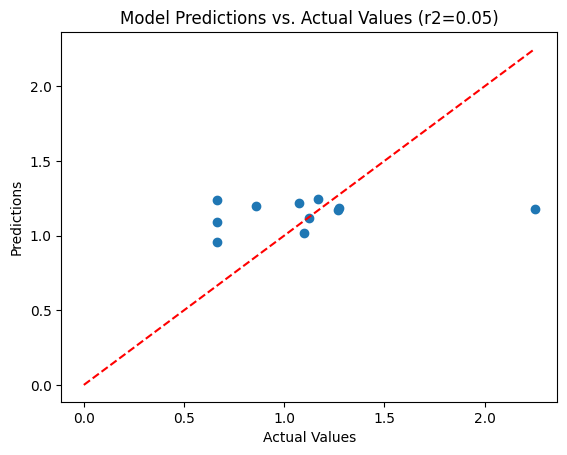

In [93]:
# Assuming you have already fitted the model and stored it in the variable 'glm_results'

predictions = glm_results.predict(X_test)

X_test['predictions'] = predictions

X_test['Total_Emerged_Adults'] = y

from sklearn.metrics import r2_score
r2 = r2_score(X_test['Total_Emerged_Adults'], X_test['predictions'])
r2

plt.scatter(X_test['Total_Emerged_Adults'], X_test['predictions'])
plt.plot([0, max(X_test['Total_Emerged_Adults'])], [0, max(X_test['Total_Emerged_Adults'])], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title(f'Model Predictions vs. Actual Values (r2={r2:.2f})')



from sklearn.metrics import r2_score
r2 = r2_score(X_test['Total_Emerged_Adults'], X_test['predictions'])
r2

In [94]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the predictors and target variable
#X = data[['value', 'ppt_avg', 'tmean_avg', 'Temp_C', 'Ag_1000m', 'Forest_1000m', 'Open_1000m', 'Other_1000m', 'ShrubWet_1000m', 'Urban_1000m', 'Apples_1000m', 'Orchard_Area_m2']]

X = data[['ppt_avg', 'tmean_avg', 'value']]
y = data['Total_Emerged_Adults']

# Add a constant term to the predictors
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)



# Create a GLM model with a Poisson distribution and log link function
glm_model = sm.GLM(y_train, X_train, family=sm.families.Poisson(link=sm.families.links.log()))
#glm_model = sm.GLM(y, X, family=sm.families.Poisson(link=sm.families.links.log()))
#glm_model = sm.GLM(y, X, family=sm.families.Gaussian())#.fit()
#glm_model = sm.GLM(y, X, family=sm.families.Gamma())#.fit()
#glm_model = sm.GLM(y, X, family=sm.families.InverseGaussian())#.fit()


# Fit the model to the data
glm_results = glm_model.fit()

# Print the summary of the GLM model
#print(glm_results.summary())

# backward elimination
print(glm_results.summary())

Training set shape: (40, 4) (40,)
Testing set shape: (11, 4) (11,)
                  Generalized Linear Model Regression Results                   
Dep. Variable:     Total_Emerged_Adults   No. Observations:                   40
Model:                              GLM   Df Residuals:                       36
Model Family:                   Poisson   Df Model:                            3
Link Function:                      log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -519.53
Date:                  Fri, 13 Sep 2024   Deviance:                       824.86
Time:                          04:44:27   Pearson chi2:                     806.
No. Iterations:                       5   Pseudo R-squ. (CS):             0.9828
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

/Users/edwardamoah/Documents/GitHub/osmiaBeePop/venv/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


0.29490879465511755

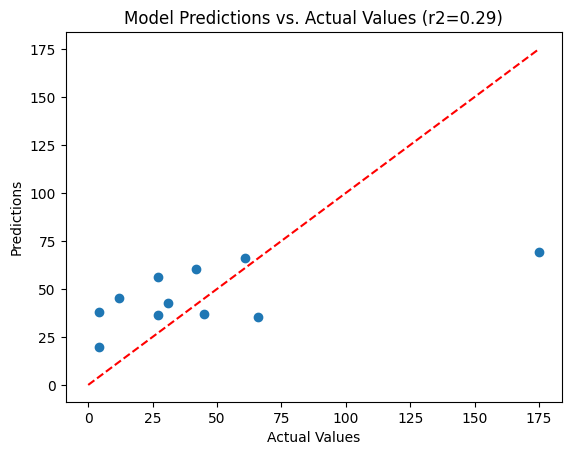

In [95]:
# Assuming you have already fitted the model and stored it in the variable 'glm_results'

predictions = glm_results.predict(X_test)

X_test['predictions'] = predictions

X_test['Total_Emerged_Adults'] = y

from sklearn.metrics import r2_score
r2 = r2_score(X_test['Total_Emerged_Adults'], X_test['predictions'])
r2

plt.scatter(X_test['Total_Emerged_Adults'], X_test['predictions'])
plt.plot([0, max(X_test['Total_Emerged_Adults'])], [0, max(X_test['Total_Emerged_Adults'])], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title(f'Model Predictions vs. Actual Values (r2={r2:.2f})')



from sklearn.metrics import r2_score
r2 = r2_score(X_test['Total_Emerged_Adults'], X_test['predictions'])
r2

In [124]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the predictors and target variable
#X = data[['value', 'ppt_avg', 'tmean_avg', 'Temp_C', 'Ag_1000m', 'Forest_1000m', 'Open_1000m', 'Other_1000m', 'ShrubWet_1000m', 'Urban_1000m', 'Apples_1000m', 'Orchard_Area_m2']]

X = data[['ppt_avg','tmean_avg', 'value']]
y = data['Total_Emerged_Adults']


# Add a constant term to the predictors
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)




# Create a GLM model with a Poisson distribution and log link function
#glm_model = sm.GLM(y_train, X_train, family=sm.families.Poisson(link=sm.families.links.log()))
glm_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial())#.fit()

# Fit the model to the data
glm_results = glm_model.fit()

# Print the summary of the GLM model
#print(glm_results.summary())

# backward elimination
print(glm_results.summary())

Training set shape: (40, 4) (40,)
Testing set shape: (11, 4) (11,)
                  Generalized Linear Model Regression Results                   
Dep. Variable:     Total_Emerged_Adults   No. Observations:                   40
Model:                              GLM   Df Residuals:                       36
Model Family:          NegativeBinomial   Df Model:                            3
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -191.79
Date:                  Fri, 13 Sep 2024   Deviance:                       21.082
Time:                          09:22:17   Pearson chi2:                     17.6
No. Iterations:                      10   Pseudo R-squ. (CS):            0.08235
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

/Users/edwardamoah/Documents/GitHub/osmiaBeePop/venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


0.13102074972185607

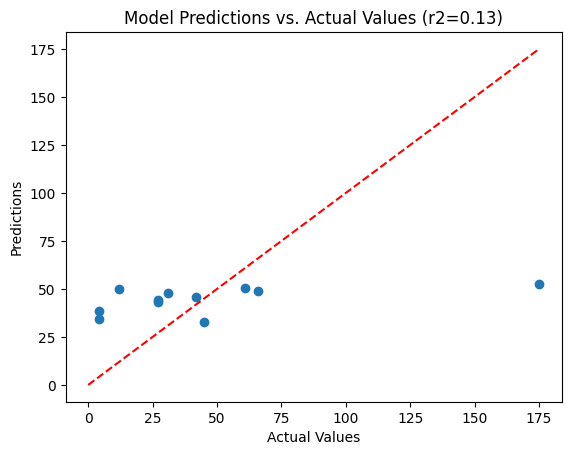

In [123]:
# Assuming you have already fitted the model and stored it in the variable 'glm_results'

predictions = glm_results.predict(X_test)

X_test['predictions'] = predictions

X_test['Total_Emerged_Adults'] = y

from sklearn.metrics import r2_score
r2 = r2_score(X_test['Total_Emerged_Adults'], X_test['predictions'])
r2

plt.scatter(X_test['Total_Emerged_Adults'], X_test['predictions'])
plt.plot([0, max(X_test['Total_Emerged_Adults'])], [0, max(X_test['Total_Emerged_Adults'])], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title(f'Model Predictions vs. Actual Values (r2={r2:.2f})')



from sklearn.metrics import r2_score
r2 = r2_score(X_test['Total_Emerged_Adults'], X_test['predictions'])
r2

In [22]:
data1 = data.dropna()

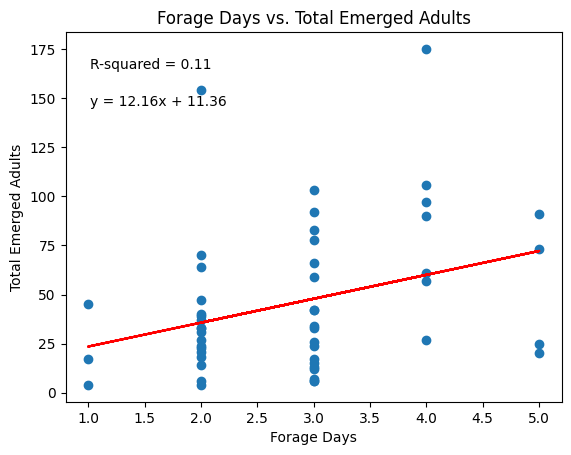

In [23]:
from scipy import stats
plt.scatter(data['forage_days'], data['Total_Emerged_Adults'])
plt.xlabel('Forage Days')
plt.ylabel('Total Emerged Adults')
plt.title('Forage Days vs. Total Emerged Adults')

# Calculate the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(data['forage_days'], data['Total_Emerged_Adults'])
regression_line = slope * data['forage_days'] + intercept

# Add the regression line to the plot
plt.plot(data['forage_days'], regression_line, color='red')

# Calculate the R-squared value
r_squared = r_value ** 2

# Add the R-squared value to the plot
plt.text(0.05, 0.9, f'R-squared = {r_squared:.2f}', transform=plt.gca().transAxes)

# Add the equation of the line to the plot
equation = f'y = {slope:.2f}x + {intercept:.2f}'
plt.text(0.05, 0.8, equation, transform=plt.gca().transAxes)

plt.show()


In [ ]:
data

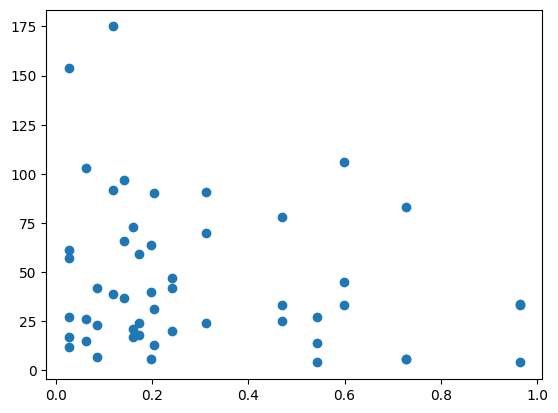

In [105]:
plt.scatter(data['Ag_250m'], data['Total_Emerged_Adults'])

In [106]:
data['Ag_250m'].corr(data['Total_Emerged_Adults'])

-0.2005179475650956

In [114]:
dt = data[["Ag_250m", 'value',"Site_Code","Total_Emerged_Adults","Total_Emerged_Females"]].groupby('Site_Code').mean()
dt

,Ag_250m,value,Total_Emerged_Adults,Total_Emerged_Females
Site_Code,,,,
AB,0.063348,0.465625,48.000000,17.666667
BA,0.598174,0.343750,61.333333,25.333333
BD,0.470320,0.378125,45.333333,25.666667
EV,0.027149,0.587500,76.000000,38.333333
GR,0.543379,0.390625,15.000000,7.333333
HG,0.203620,0.565625,44.666667,20.000000
HS,0.172727,0.396875,33.666667,21.333333
IC,0.312217,0.443750,61.666667,29.000000
IT,0.142202,0.443750,66.666667,34.000000


In [116]:
dt['value'].corr(dt['Total_Emerged_Females'])

0.1816545664214491

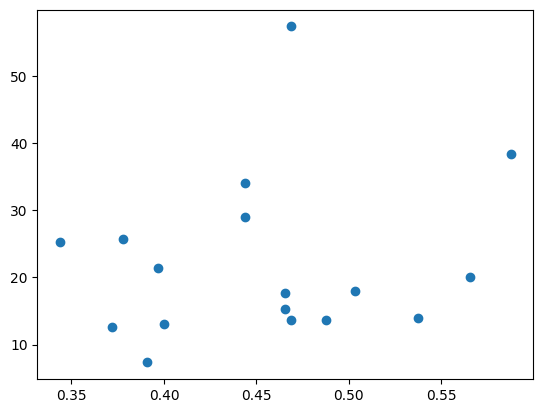

In [117]:
plt.scatter(dt['value'], dt['Total_Emerged_Females'])

In [126]:
def totalProvision(emerged, mortality):

    return ((emerged * mortality)/(1 - mortality)) + emerged

In [131]:
data['Total_Provisioned'] = data.apply(lambda x: totalProvision(x['Total_Emerged_Adults'], x['Proportion_Larval_Mortality']), axis=1)

In [132]:
data['Total_Provisioned'].corr(data['value'])

0.09035210598119967

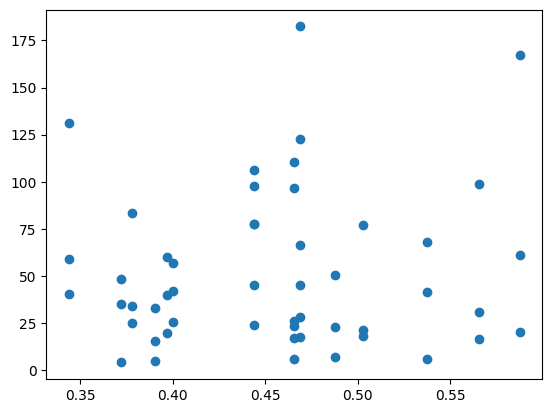

In [168]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the predictors and target variable
#X = data[['value', 'ppt_avg', 'tmean_avg', 'Temp_C', 'Ag_1000m', 'Forest_1000m', 'Open_1000m', 'Other_1000m', 'ShrubWet_1000m', 'Urban_1000m', 'Apples_1000m', 'Orchard_Area_m2']]

X = data[['ppt_avg','tmean_avg','value']]
y = data['Total_Provisioned']


# Add a constant term to the predictors
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)




# Create a GLM model with a Poisson distribution and log link function
#glm_model = sm.GLM(y_train, X_train, family=sm.families.Poisson(link=sm.families.links.log()))
glm_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial())#.fit()

# Fit the model to the data
glm_results = glm_model.fit()

# Print the summary of the GLM model
#print(glm_results.summary())

# backward elimination
print(glm_results.summary())

Training set shape: (40, 4) (40,)
Testing set shape: (11, 4) (11,)
                 Generalized Linear Model Regression Results                  
Dep. Variable:      Total_Provisioned   No. Observations:                   40
Model:                            GLM   Df Residuals:                       36
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -196.70
Date:                Fri, 13 Sep 2024   Deviance:                       20.103
Time:                        19:29:31   Pearson chi2:                     18.3
No. Iterations:                    11   Pseudo R-squ. (CS):            0.08246
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------

/Users/edwardamoah/Documents/GitHub/osmiaBeePop/venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


0.3307393663690533

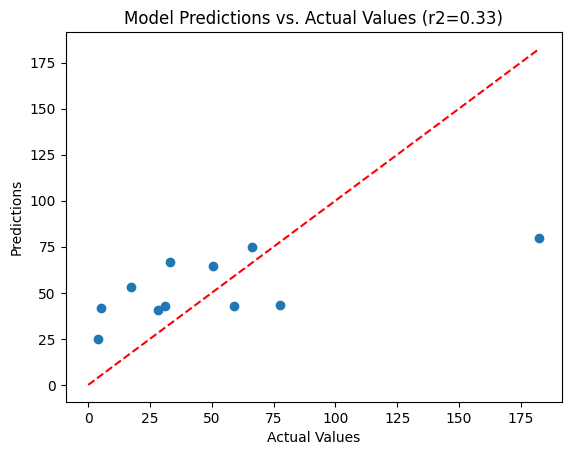

In [169]:
# Assuming you have already fitted the model and stored it in the variable 'glm_results'

predictions = glm_results.predict(X_test)

X_test['predictions'] = predictions

X_test['Total_Emerged_Adults'] = y

from sklearn.metrics import r2_score
r2 = r2_score(X_test['Total_Emerged_Adults'], X_test['predictions'])
r2

plt.scatter(X_test['Total_Emerged_Adults'], X_test['predictions'])
plt.plot([0, max(X_test['Total_Emerged_Adults'])], [0, max(X_test['Total_Emerged_Adults'])], color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title(f'Model Predictions vs. Actual Values (r2={r2:.2f})')



from sklearn.metrics import r2_score
r2 = r2_score(X_test['Total_Emerged_Adults'], X_test['predictions'])
r2

In [164]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X_test['Total_Emerged_Adults'], X_test['predictions'])

1518.779659806926

In [165]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Example data (X is the predictor matrix, y is the dependent variable)
# X, y = ... (your dataset)

X = data[['ppt_avg','tmean_avg','value']]
y = data['Total_Provisioned']

# Add a constant to X (to include the intercept in the model)
X = sm.add_constant(X)

# Set up k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# List to store the MSE for each fold
mse_scores = []

# Loop through the folds
for train_index, test_index in kf.split(X):
    # Split data into training and testing sets
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    # Fit the Negative Binomial model on the training set
    model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial()).fit()

    print(model.summary())
    
    # Predict on the validation/test set
    y_pred = model.predict(X_test)
    
    # Calculate Mean Squared Error (MSE) on the validation set
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Calculate the average MSE across all folds
average_mse = np.mean(mse_scores)

print(f"Average MSE across all folds: {average_mse}")


                 Generalized Linear Model Regression Results                  
Dep. Variable:      Total_Provisioned   No. Observations:                   40
Model:                            GLM   Df Residuals:                       36
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -196.70
Date:                Fri, 13 Sep 2024   Deviance:                       20.103
Time:                        11:10:13   Pearson chi2:                     18.3
No. Iterations:                    11   Pseudo R-squ. (CS):            0.08246
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9272      1.859      1.575      0.1

/Users/edwardamoah/Documents/GitHub/osmiaBeePop/venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/edwardamoah/Documents/GitHub/osmiaBeePop/venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/edwardamoah/Documents/GitHub/osmiaBeePop/venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/Users/edwardamoah/Documents/GitHub/osmiaBeePop/venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1